Dataset: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset

https://www.kaggle.com/code/sayamkumar/weather-image-recognition-using-cnn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from torchsummary import summary
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
import cv2
from tqdm import tqdm

import kagglehub

# Configs

In [ ]:
if torch.cuda.is_available():
    print("Device:",torch.cuda.current_device())
    print("Device Name:",torch.cuda.get_device_name())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Device: 0
Device Name: Tesla T4


In [ ]:
image_size = 224
batch_size = 32
num_workers = 2
learning_rate = 1e-4
num_epoch = 10

# Data Loading

In [ ]:
# train_set = torchvision.datasets.Flowers102(root='./data', split='train',
#                                           download=True, transform=transforms.Compose([transforms.Resize((image_size, image_size)),
#                                                                                         transforms.ToTensor()]))

# val_set = torchvision.datasets.Flowers102(root='./data', split='val',
#                                           download=False, transform=transforms.Compose([transforms.Resize((image_size, image_size)),
#                                                                                         transforms.ToTensor()]))

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
#                                           shuffle=True, num_workers=num_workers)

# val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
#                                          shuffle=False, num_workers=num_workers)

In [ ]:
img_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.4),
    transforms.RandomVerticalFlip(0.3),
    transforms.Resize((240,240)),
    transforms.CenterCrop((240,240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
img_transforms

Compose(
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.4)
    RandomVerticalFlip(p=0.3)
    Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(240, 240))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")

print("Path to dataset files:", path)

100%|██████████| 587M/587M [00:06<00:00, 88.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3


In [ ]:
dataset = torchvision.datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset", transform=img_transforms)

In [ ]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [ ]:
len(dataset)

6862

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset=dataset,lengths=[0.8,0.2])

In [ ]:
# train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")
# test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=32,shuffle=True)

## Visualize image samples

In [ ]:
for images, labels in train_loader:
    break

torch.Size([32, 3, 240, 240])
torch.Size([32])


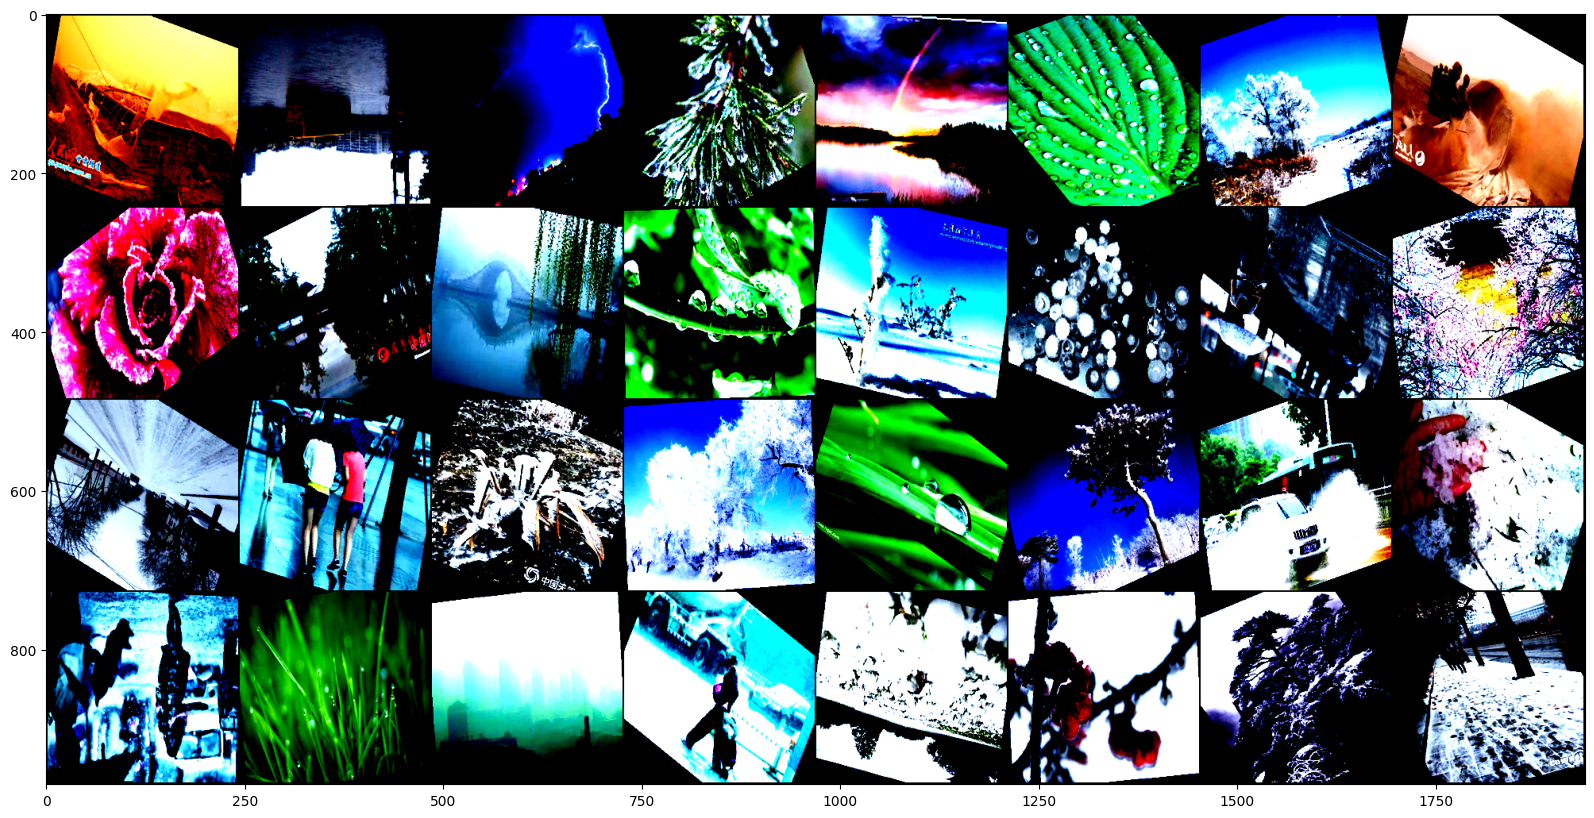

In [ ]:
img_grid = torchvision.utils.make_grid(images,nrow=8)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_normalized_images = inv_normalize(images)

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(img_grid.numpy(),(1,2,0)));

In [ ]:
images.shape

torch.Size([32, 3, 240, 240])

In [ ]:
# Function to count samples per class
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    return label_count

In [ ]:
label_count = count_samples_per_class(train_set)
num_classes = len(label_count)
print("Total number of data: ", len(train_set))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  5490
Number of classes: 11
Number of data samples per class: Counter({8: 937, 1: 673, 0: 556, 9: 536, 3: 526, 10: 486, 4: 480, 6: 425, 2: 383, 5: 303, 7: 185})


In [ ]:
label_count = count_samples_per_class(test_set)
num_classes = len(label_count)
print("Total number of data: ", len(test_set))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  1372
Number of classes: 11
Number of data samples per class: Counter({8: 223, 1: 178, 9: 156, 0: 142, 10: 135, 3: 113, 4: 111, 6: 101, 2: 92, 5: 74, 7: 47})


# CNN Model

In [ ]:
resnet_model = torchvision.models.resnet18(weights='IMAGENET1K_V1').cuda()
# resnet_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet_model.parameters(), lr=learning_rate)

# **Model Evaluation without modification**

In [ ]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet_model.fc = nn.Linear(512, 102)

In [ ]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet_model = resnet_model.cuda()

In [ ]:
val_running_loss = 0.0
val_running_accuracy = 0.0
idx = 0
for idx, data in enumerate(test_loader):


  images, labels = data
  images = images.cuda()
  labels = labels.cuda()

  pred = resnet_model(images)

  loss = loss_fn(pred, labels)

  val_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())


  if idx == 10:
    break

print(f"Validation Loss is {val_running_loss}")
print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")

Validation Loss is 59.08169651031494
Validation Accuracy is 0.0


# Retraining

In [ ]:
for p in resnet_model.parameters():
  p.requires_grad = False # Weights are freezed if false

In [ ]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# resnet_model.fc = nn.Linear(512, 102)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 11)

In [ ]:
resnet_model = resnet_model.cuda()

In [ ]:
summary(resnet_model, (3, 224, 224))

In [ ]:
best_val_accuracy = 0
for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

172it [00:51,  3.36it/s]


Training Loss at epoch 0 is 424.1346037387848
Training Accuracy at epoch 0 is 0.10907218992248063


172it [00:50,  3.42it/s]


Training Loss at epoch 1 is 423.062611579895
Training Accuracy at epoch 1 is 0.10489341085271318


172it [00:50,  3.41it/s]


Training Loss at epoch 2 is 423.70725417137146
Training Accuracy at epoch 2 is 0.11038436692506459


172it [00:50,  3.42it/s]


Training Loss at epoch 3 is 424.13479375839233
Training Accuracy at epoch 3 is 0.11161579457364341


172it [00:49,  3.44it/s]


Training Loss at epoch 4 is 424.45863342285156
Training Accuracy at epoch 4 is 0.10878956718346254


172it [00:50,  3.40it/s]


Training Loss at epoch 5 is 423.2330837249756
Training Accuracy at epoch 5 is 0.10638727390180878


172it [00:50,  3.41it/s]


Training Loss at epoch 6 is 423.1657876968384
Training Accuracy at epoch 6 is 0.11038436692506459


172it [00:50,  3.40it/s]


Training Loss at epoch 7 is 424.39814257621765
Training Accuracy at epoch 7 is 0.11113129844961239


172it [00:50,  3.41it/s]


Training Loss at epoch 8 is 424.01764726638794
Training Accuracy at epoch 8 is 0.10511547157622739


172it [00:50,  3.41it/s]

Training Loss at epoch 9 is 424.0864460468292
Training Accuracy at epoch 9 is 0.10220849483204134


# More Retraining

In [ ]:
for p in resnet_model.named_parameters():
  # print(p[0])
  if 'layer4' in p[0]:
    p[1].requires_grad = True

In [ ]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
best_val_accuracy = 0
for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

172it [00:53,  3.23it/s]


Training Loss at epoch 0 is 118.7596103399992
Training Accuracy at epoch 0 is 0.7873263888888888


172it [00:53,  3.23it/s]


Training Loss at epoch 1 is 61.76326660066843
Training Accuracy at epoch 1 is 0.8791787790697675


172it [00:53,  3.21it/s]


Training Loss at epoch 2 is 48.448051273822784
Training Accuracy at epoch 2 is 0.9076025516795866


172it [00:53,  3.22it/s]


Training Loss at epoch 3 is 40.049009665846825
Training Accuracy at epoch 3 is 0.9255490956072352


172it [00:53,  3.23it/s]


Training Loss at epoch 4 is 33.71114665828645
Training Accuracy at epoch 4 is 0.9362685723514212


172it [00:52,  3.26it/s]


Training Loss at epoch 5 is 28.41768327727914
Training Accuracy at epoch 5 is 0.9471697351421189


172it [00:53,  3.24it/s]


Training Loss at epoch 6 is 24.92326558381319
Training Accuracy at epoch 6 is 0.9569404069767442


172it [00:53,  3.24it/s]


Training Loss at epoch 7 is 23.14764902740717
Training Accuracy at epoch 7 is 0.9580708979328166


172it [00:54,  3.16it/s]


Training Loss at epoch 8 is 19.07668337225914
Training Accuracy at epoch 8 is 0.9646519702842377


172it [00:53,  3.23it/s]

Training Loss at epoch 9 is 17.49815959390253
Training Accuracy at epoch 9 is 0.9678415697674418


# Evaluate

In [ ]:
val_running_loss = 0.0
val_running_accuracy = 0.0
idx = 0
for idx, data in enumerate(test_loader):


  images, labels = data
  images = images.cuda()
  labels = labels.cuda()

  pred = resnet_model(images)

  loss = loss_fn(pred, labels)

  val_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())


  if idx == 10:
    break

print(f"Validation Loss is {val_running_loss}")
print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")

Validation Loss is 4.601577416062355
Validation Accuracy is 0.8806818181818182


# Save Model

In [ ]:
torch.save(resnet_model.state_dict(), 'weather_class_model_trained.pth')